## Week6

In this part, we'll load a pre-trained network and play with it.

In [1]:
from __future__ import print_function
from sys import version_info

import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import theano
import theano.tensor as T
import lasagne

try:
    import cPickle as pickle
except ImportError:
    import pickle

%matplotlib inline

from scipy.misc import imread, imsave, imresize
from lasagne.utils import floatX

# Model Zoo (4 pts)
Lasagne has a plethora of pre-training netrworks in the [model zoo](https://github.com/Lasagne/Recipes/tree/master/modelzoo)
* Even more models within the community (neighbor repos, PRs, etc.)


We'll start by picking VGG16 and deploying it in our notebook.

__Warning!__ VGG16 network requires around 3GB of memory to predict event for single-image batch. If you don't have that luxury, try [binder](http://mybinder.org/repo/yandexdataschool/practical_rl) or [azure notebooks](http://notebooks.azure.com/).


In [2]:
# copyright: see http://www.robots.ox.ac.uk/~vgg/research/very_deep/


from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.nonlinearities import softmax


def build_model():
    net = {}
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1_1'] = ConvLayer(
        net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(
        net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(
        net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(
        net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(
        net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(
        net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(
        net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_3'], 2)
    net['conv4_1'] = ConvLayer(
        net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(
        net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(
        net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    net['conv5_1'] = ConvLayer(
        net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(
        net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(
        net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_3'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
    net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=4096)
    net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5)
    net['fc8'] = DenseLayer(
        net['fc7_dropout'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)

    return net

In [3]:
#classes' names are stored here
classes = pickle.load(open('classes.pkl', 'rb'))
#for example, 10th class is ostrich:
print(classes[9])

ostrich, Struthio camelus


You have to implement two functions in the cell below.

Preprocess function should take the image with shape (w, h, 3) and transform it into a tensor with shape (1, 3, 224, 224). Without this transformation, our net won't be able to digest input image. 
Additionally, your preprocessing function have to rearrange channels RGB -> BGR and subtract mean values from every channel.

In [11]:
MEAN_VALUES = np.array([104, 117, 123])
IMAGE_W = 224

def preprocess(img):
    img = img[:, :, ::-1]
    mean_values = MEAN_VALUES
    img = img - mean_values
    
    #convert from [w,h,3 to 1,3,w,h]
    img = np.transpose(img, (2, 0, 1))[None]
    return floatX(img)

def deprocess(img):
    img = img.reshape(img.shape[1:]).transpose((1, 2, 0))
    for i in range(3):
        img[:,:, i] += MEAN_VALUES[i]
    return img[:, :, :: -1].astype(np.uint8)

img = (np.random.rand(IMAGE_W, IMAGE_W, 3) * 256).astype(np.uint8)

print(np.linalg.norm(deprocess(preprocess(img)) - img))

0.0


If your implementation is correct, the number above will be small, because deprocess function is the inverse of preprocess function

### Deploy the network

In [12]:
net = build_model()

In [26]:
with open('vgg16.pkl', 'rb') as f:
    if version_info.major == 2:
        weights = pickle.load(f)
    elif version_info.major == 3:
        weights = pickle.load(f, encoding='latin1')

In [25]:
from lasagne.layers import set_all_param_values
set_all_param_values(net['prob'], weights['param values'])

In [27]:
input_image = T.tensor4('input')
output = lasagne.layers.get_output(net['prob'], input_image)

prob = theano.function([input_image], output) 

### Sanity check
Let's make sure our network actually works. 

To do so, we'll feed it with some example images.

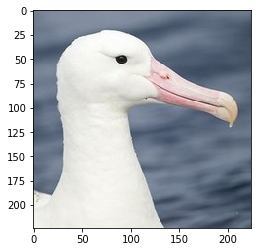

top-5 classes are:
0.976642	albatross
0.023264	goose
0.000057	drake
0.000010	European gallinule
0.000009	ptarmigan


In [28]:
img = imread('sample_images/albatross.jpg')
plt.imshow(img)
plt.show()

p = prob(preprocess(img))

labels = p.ravel().argsort()[-1:-6:-1]
print('top-5 classes are:')
for l in labels:
    print('%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0]))

##### Ouch!
Try running network 2-3 times. If output changes, then we've probably done something wrong.

Figure out, what's the problem with the network.

_hint_ there are two such 'problematic' layers in vgg16. They're all near the end.

You can make network deterministic by giving it such flag in the `lasagne.layers.get_output` function above.

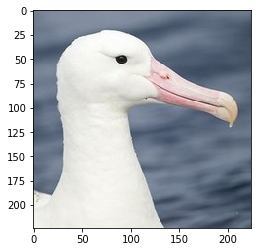

top-5 classes are:
0.955846	albatross
0.044095	goose
0.000016	drake
0.000013	red-breasted merganser
0.000008	American egret


In [32]:
img = imread('sample_images/albatross.jpg')
plt.imshow(img)
plt.show()

p = prob(preprocess(img))

labels = p.ravel().argsort()[-1:-6:-1]
print('top-5 classes are:')
for l in labels:
    print('%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0]))

In [33]:
input_image = T.tensor4('input')
output = lasagne.layers.get_output(net['prob'], input_image, deterministic=True)

prob = theano.function([input_image], output) 

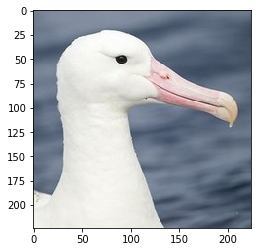

top-5 classes are:
0.996280	albatross
0.003715	goose
0.000001	drake
0.000001	white stork
0.000001	spoonbill


In [36]:
img = imread('sample_images/albatross.jpg')
plt.imshow(img)
plt.show()

p = prob(preprocess(img))

labels = p.ravel().argsort()[-1:-6:-1]
print('top-5 classes are:')
for l in labels:
    print('%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0]))

Вот теперь deterministic

#### Fun opportunity

ImageNet does not contain any human classes, so if you feed the network with some human photo, it will most likely hallucinate something which is closest to your image.

Try feeding the network with something peculiar: your avatar, Donald Trump, Victor Lempitsky or anyone.

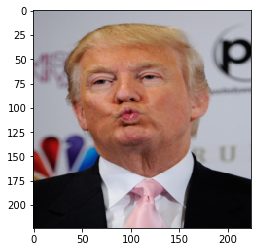

top-5 classes are:
0.297998	suit
0.295361	Windsor tie
0.169999	groom
0.082395	bow tie
0.046685	oboe


In [39]:
img = imread('Trump3.jpg')
img = imresize(img, (IMAGE_W, IMAGE_W))
plt.imshow(img)
plt.show()

p = prob(preprocess(img))

labels = p.ravel().argsort()[-1:-6:-1]
print('top-5 classes are:')
for l in labels:
    print('%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0]))

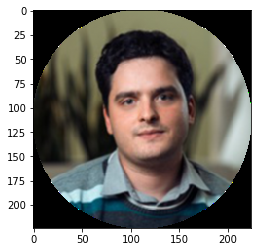

top-5 classes are:
0.102690	toilet seat
0.075529	loupe
0.065889	car mirror
0.036644	gong
0.036448	pick


In [43]:
img = imread('viktor_lempickiy.png')
img = imresize(img, (IMAGE_W, IMAGE_W))[:, :, :3]
plt.imshow(img)
plt.show()

p = prob(preprocess(img))

labels = p.ravel().argsort()[-1:-6:-1]
print('top-5 classes are:')
for l in labels:
    print('%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0]))

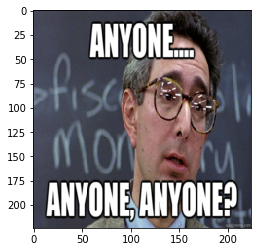

top-5 classes are:
0.676000	book jacket
0.042254	scoreboard
0.027506	jersey
0.022816	racket
0.022693	comic book


In [45]:
img = imread('anyone.jpg')
img = imresize(img, (IMAGE_W, IMAGE_W))
plt.imshow(img)
plt.show()

p = prob(preprocess(img))

labels = p.ravel().argsort()[-1:-6:-1]
print('top-5 classes are:')
for l in labels:
    print('%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0]))

# Grand-quest: Dogs Vs Cats (6 pts)
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [46]:
!wget https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip data.zip
#you may need to adjust paths in the next section, depending on your OS

--2017-03-24 10:13:25--  https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 64:ff9b::a27d:5001
Connecting to www.dropbox.com (www.dropbox.com)|64:ff9b::a27d:5001|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/mIq5IppLtPFwq6As4twf8mEno8t9RDC7i6MDWsWwTQsO4bK0TpnM59pyNQfgam7Y/file?dl=1 [following]
--2017-03-24 10:13:26--  https://dl.dropboxusercontent.com/content_link/mIq5IppLtPFwq6As4twf8mEno8t9RDC7i6MDWsWwTQsO4bK0TpnM59pyNQfgam7Y/file?dl=1
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 64:ff9b::a27d:4206
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|64:ff9b::a27d:4206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 569546721 (543M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 543,16M  26,0MB/s    in 24s     

2017-03-24 10:13:51 (22,9 

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

Возьмём fc7, посчитанный Григорием Стрижовым

In [48]:
with open('fc7_features.pkl', 'rb') as f:
    if version_info.major == 2:
        fc7 = pickle.load(f)
    elif version_info.major == 3:
        fc7 = pickle.load(f, encoding='latin1')

In [50]:
X, Y = fc7

In [51]:
X.shape

(25000, 4096)

In [53]:
Y = np.array(Y)
Y.shape

(25000,)

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)

__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [58]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Main quest

* Get the score improved!

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.

The main requirement is that you implement the NN fine-tuning recipe:
### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k
### Choose which vgg layers are you going to use
  * Anything but for prob is okay
  * Do not forget that vgg16 uses dropout
### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output
### Train the newly added layers for some iterations
  * you can selectively train some weights by only sending them to your optimizer
      * `lasagne.updates.mysupermegaoptimizer(loss, only_those_weights_i_wanna_train)`
  * selecting all weights from the head but not below the neck:
      * `all_params = lasagne.layers.get_all_params(new_output_layer_or_layers,trainable=True)`
      * `old_params= lasagne.layers.get_all_params(neck_layers,trainable=True)`
      * `new_params = [w for w in all_params if w not in old_params]`
  * it's cruicial to monitor the network performance at this and following steps
### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate
      * since updates are dictionaries, one can just compute union
      * `updates = {}`
      * `updates.update(lasagne.updates.how_i_optimize_old_weights())`
      * `updates.update(lasagne.updates.how_i_optimize_old_weights())`
      * make sure they do not have overlapping keys. Otherwise, earlier one will be forgotten.
      * `assert len(updates) == len(old_updates) + len(new_updates)`
### PROFIT!!!
  * Evaluate the final score
  * Submit to kaggle
      * competition page https://www.kaggle.com/c/dogs-vs-cats
      * get test data https://www.kaggle.com/c/dogs-vs-cats/data
  
## Some ways to get bonus points
* explore other networks from the model zoo
* play with architecture
* 85%/90%/93%/95%/97% kaggle score (screen pls).
* data augmentation, prediction-time data augmentation
* use any more advanced fine-tuning technique you know/read anywhere
* ml hacks that benefit the final score


In [57]:
print("I can do it!")

I can do it!


Попробуем логистическую регрессию и найдём по кросс-валидации наилучший коэффициент l2-регуляризатора. В качестве метрики будет accuracy

In [60]:
est = LogisticRegressionCV(cv=5, n_jobs=-1).fit(X_train, y_train)
est

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [62]:
est.Cs_

array([  1.00000000e-04,   7.74263683e-04,   5.99484250e-03,
         4.64158883e-02,   3.59381366e-01,   2.78255940e+00,
         2.15443469e+01,   1.66810054e+02,   1.29154967e+03,
         1.00000000e+04])

In [63]:
est.C_

array([ 0.00599484])

In [64]:
est.scores_

{True: array([[ 0.985  ,  0.98825,  0.9865 ,  0.985  ,  0.98325,  0.98225,
          0.98225,  0.98225,  0.98225,  0.98225],
        [ 0.9805 ,  0.9825 ,  0.98375,  0.98325,  0.98225,  0.98175,
          0.982  ,  0.98225,  0.98125,  0.9815 ],
        [ 0.985  ,  0.98475,  0.98625,  0.9855 ,  0.98475,  0.984  ,
          0.98225,  0.9815 ,  0.9815 ,  0.982  ],
        [ 0.98375,  0.9855 ,  0.98475,  0.98275,  0.98175,  0.98   ,
          0.9805 ,  0.98025,  0.98075,  0.9805 ],
        [ 0.983  ,  0.9835 ,  0.9845 ,  0.9835 ,  0.982  ,  0.9815 ,
          0.98125,  0.981  ,  0.981  ,  0.98075]])}

In [65]:
est.score(X_test, y_test)

0.98960000000000004

Пооптимизируем logloss

In [69]:
ll_est = LogisticRegressionCV(cv=5, n_jobs=-1, scoring='neg_log_loss').fit(X_train, y_train)

In [70]:
from sklearn.metrics import log_loss
log_loss(y_test, ll_est.predict_proba(X_test))

0.034627703165023241

Попробуем залить на kaggle

In [71]:
with open('fc7_TEST.pkl', 'rb') as f:
    if version_info.major == 2:
        fc7_test = pickle.load(f)
    elif version_info.major == 3:
        fc7_test = pickle.load(f, encoding='latin1')

In [74]:
predicted = ll_est.predict_proba(fc7_test[0])

In [75]:
import pandas as pd

In [81]:
df = pd.DataFrame()
df['id'] = fc7_test[1]
df['label'] = predicted[:, 0]
df.to_csv('kaggle.csv', index=False)

Получили 0.06917

![](./score.png)

Тут я пытался обучить SVC, но потратил день зря

Посмотрим на RF

In [92]:
from sklearn.model_selection import GridSearchCV

parameters = {'criterion': ['gini', 'entropy']}

search = GridSearchCV(RandomForestClassifier(n_estimators=100),
                      parameters, n_jobs=-1, cv=5, scoring='neg_log_loss').fit(
    X_train, y_train)

In [93]:
search.best_params_

{'criterion': 'entropy'}

In [94]:
log_loss(y_test, search.best_estimator_.predict_proba(X_test))

0.069257808290614911